<a href="https://www.kaggle.com/code/houssemaminetouihri/arima-for-stock-market?scriptVersionId=105312172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

If you like this kernel, please give it an upvote. Thank you!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from warnings import simplefilter

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Even here, i'll be working with Tesla Stock Market

In [2]:
df = pd.read_csv("../input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsla.us.txt")
df.head(10)


,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0
5,2010-07-06,20.00,20.00,15.83,16.11,6879296,0
6,2010-07-07,16.40,16.63,14.98,15.80,6924914,0
7,2010-07-08,16.14,17.52,15.57,17.46,7719539,0
8,2010-07-09,17.58,17.90,16.55,17.40,4058606,0
9,2010-07-12,17.95,18.07,17.00,17.05,2203570,0


In [3]:
cols=['Date','Close']
df1=df.loc[:,cols]
df1["Date"]=pd.to_datetime(df1["Date"])
df1 = df1.set_index("Date")
df1

,Close
Date,
2010-06-28,17.00
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
...,...
2017-11-06,302.78
2017-11-07,306.05
2017-11-08,304.31


<AxesSubplot:xlabel='Date'>

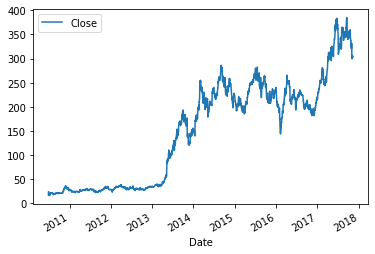

In [4]:
df1.plot()

# Finding the order of differencing (d)


**The purpose of differencing it to make the time series stationary.**

Statistical stationarity:  **A stationary time series** is one whose statistical properties such as mean, variance, autocorrelation, etc .... are all constant over time.  
Thus, **time series with trends, or with seasonality, are not stationary** — the trend and seasonality will affect the value of the time series at different times.  
Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations.   
A stationarized series is relatively **easy to predict**: you simply predict that its statistical properties will be the same in the future as they have been in the past! 

In general, a stationary time series will have no predictable patterns in the long-term.   
 **Time plots** will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

##### Examples 
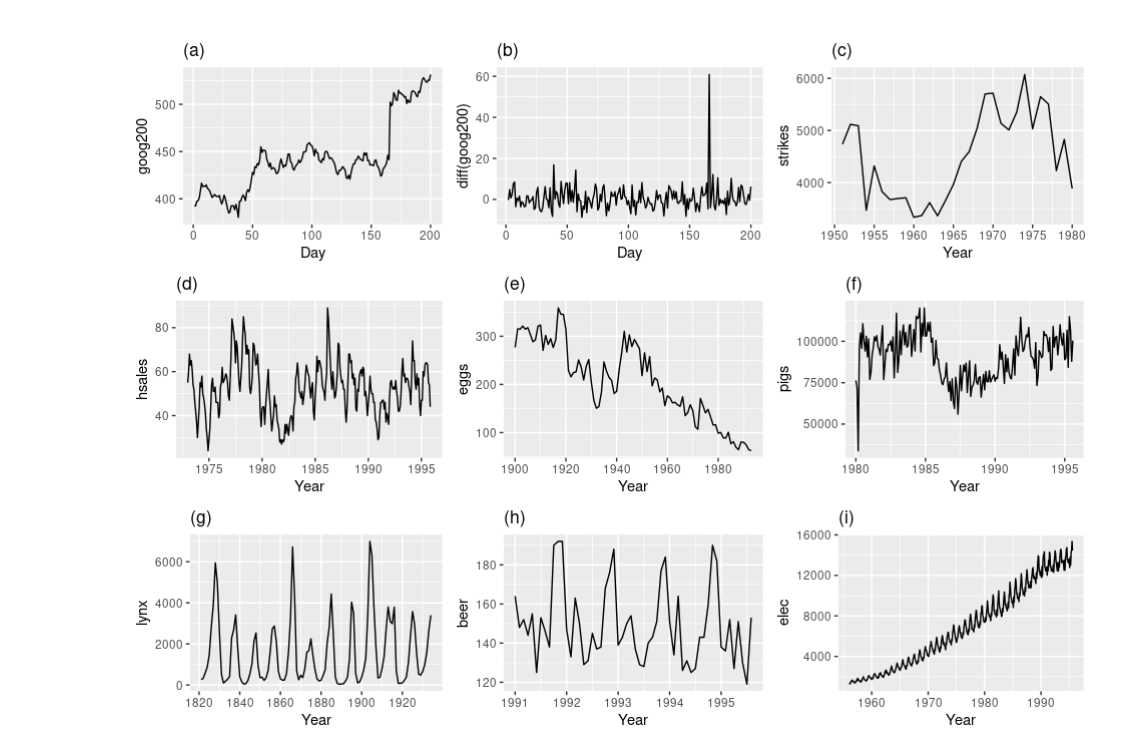
  
  Obvious seasonality rules out series (d), (h) and (i).  
  Trends and changing levels rules out series (a), (c), (e), (f) and (i).  
  Increasing variance also rules out (i).   
  That leaves **only (b) and (g) as stationary series**.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

In [5]:
result = adfuller(df1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.842866
p-value: 0.806205


**P Value>0.05** we go ahead with finding the order of differencing.

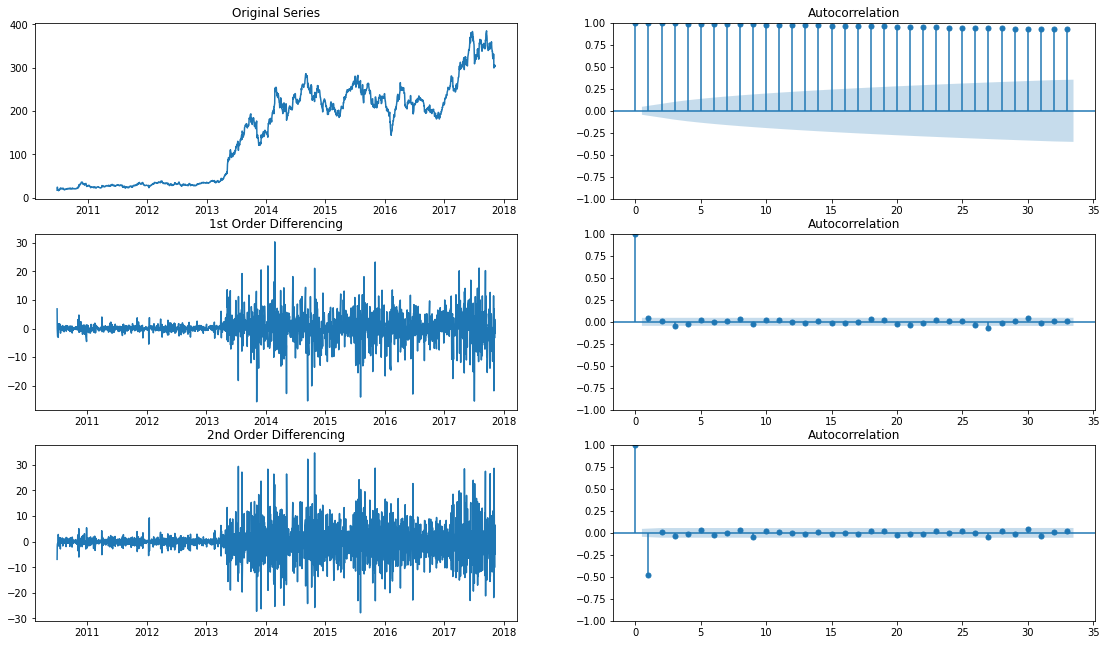

In [6]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(19, 11))
axes[0, 0].plot(df1)
axes[0, 0].set_title('Original Series')
plot_acf(df1, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df1.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
#whydropna(NB dropna made the code work)

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and **the ACF plot reaches to zero fairly quick.**

**If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing.**  
On the other hand, **if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced** ( looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.)

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.   
So here we decided that d=1

In [7]:
d=1

# How to find the order of the AR term (p)


The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation **(PACF) plot.**
#### But what is PACF?

**Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.  


/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


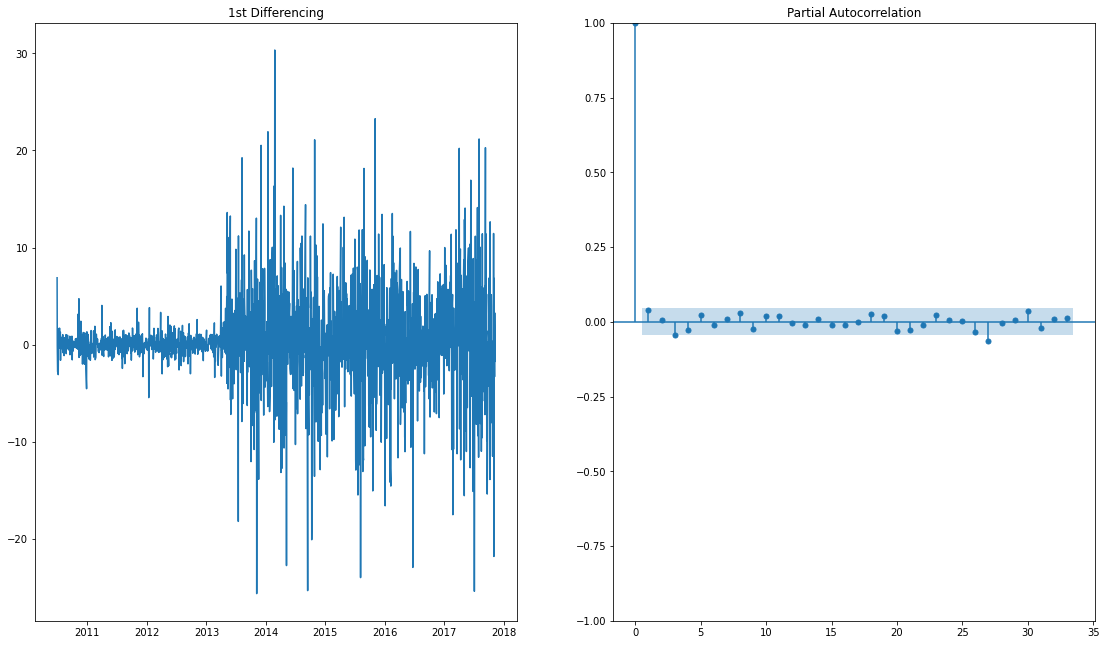

In [8]:
# PACF plot of 1st differenced series


fig, axes = plt.subplots(1, 2, figsize=(19, 11))
axes[0].plot(df1.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1.diff().dropna(), ax=axes[1])

plt.show() 

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

the partial autocorrelation "cuts off"/ceases to be significant at  lag2 this indicates that that lag does not add explanatory power to a model and therefore that the AR order should be the previous lag.  
That's why i am fixing p as 1

In [9]:
p=1

**To sum up, understanding ACF and PACF plots are necessary to identify the order of AR and MA terms for choosing appropriate candidate models.**

# How to find the order of the MA term (q)

An MA term is technically, the error of the lagged forecast.  
The **ACF** tells how many MA terms are required to remove any autocorrelation in the stationarized series.  
Let’s see the autocorrelation plot of the differenced series.

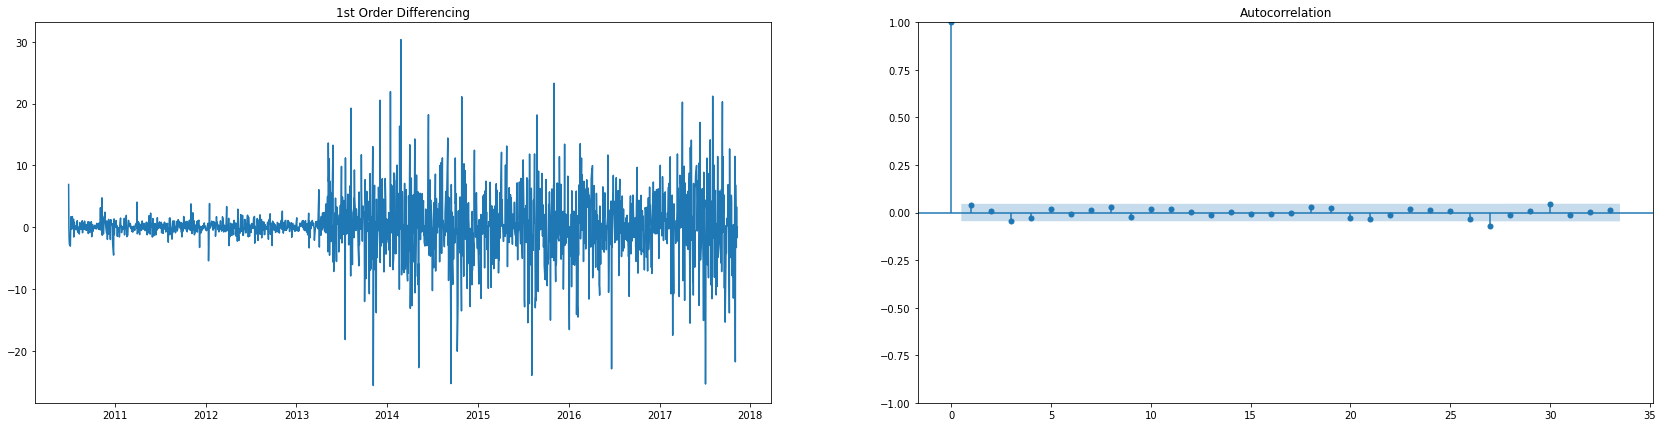

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(29,7))
# 1st Differencing
axes[0].plot(df1.diff())
axes[0].set_title('1st Order Differencing')
plot_acf(df1.diff().dropna(), ax=axes[1])
plt.show()

No lags above the significance line so let's tentatively fix q as 0

In [11]:
q=0

# Building the ARIMA Model 

In [12]:
model = ARIMA(df1, order=(d,p,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1858
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5542.703
Date:                Fri, 09 Sep 2022   AIC                          11089.405
Time:                        23:05:14   BIC                          11100.459
Sample:                             0   HQIC                         11093.479
                               - 1858                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0405      0.017      2.431      0.015       0.008       0.073
sigma2        22.9116      0.387     59.216      0.000      22.153      23.670
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the **weights** of the respective terms.
#### Explanation of the output
in progress ...

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).  
in progress ...

**Let’s plot the actuals against the fitted values**

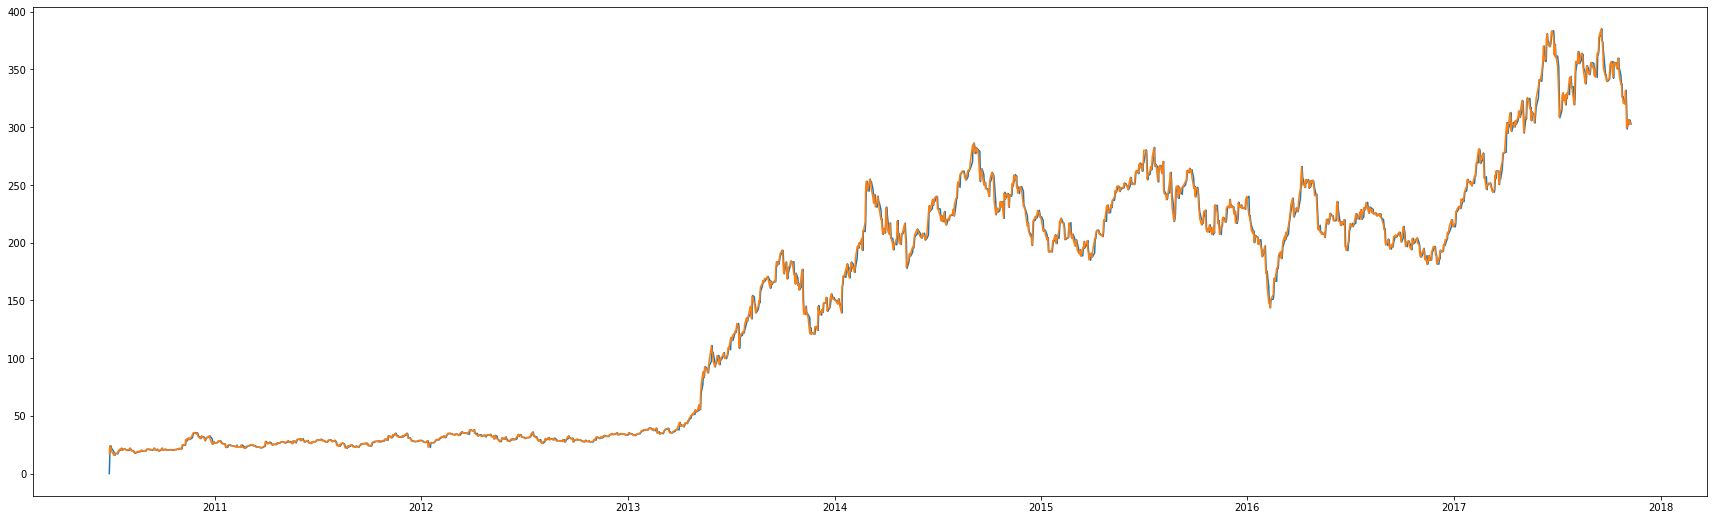

In [13]:
# Actual vs Fitted
plt.figure(figsize=(30, 9))
X=model_fit.predict()

plt.plot(X,label='predicted')
plt.plot(df1,label='original')

plt.show()

<AxesSubplot:xlabel='Date'>

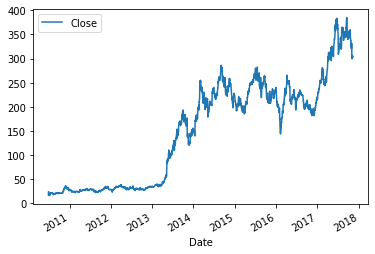

In [14]:
df1.plot()

In progress ... 